In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    roc_auc_score, confusion_matrix, f1_score,
    recall_score, precision_score, accuracy_score
)
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
def evaluate_model(model, X_val, y_val, model_name, threshold):
    """
    Evaluates a model and prints metrics + plots confusion matrix.
    """
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_val)[:, 1]
        y_pred = (y_pred_prob >= threshold).astype(int)
    else:
        y_pred = model.predict(X_val)
        y_pred_prob = None

    print(f"\n--- {model_name} ---")
    if y_pred_prob is not None:
        print("ROC-AUC:", roc_auc_score(y_val, y_pred_prob))
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print("F1-score:", f1_score(y_val, y_pred))
    print("Precision:", precision_score(y_val, y_pred))
    print("Recall:", recall_score(y_val, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Good Loans", "Bad Loans"], yticklabels=["Good Loans", "Bad Loans"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Load data

In [3]:
train_df = pd.read_csv('lc_loan.csv')
print(train_df.shape)

# Load test dataset
test_df = pd.read_csv("lc_2016_2017.csv")
print(test_df.shape)# adjust path

(887379, 74)
(759338, 72)


# Define Target Variable

In [4]:
bad_status = [
    "Charged Off",
    "Default",
    "Late (31-120 days)",
    "Late (16-30 days)"
]

train_df["target"] = train_df["loan_status"].apply(
    lambda x: 1 if x in bad_status else 0
)

# Define Target variable
bad_status = [
    "Charged Off",
    "Default",
    "Late (31-120 days)",
    "Late (16-30 days)"
]

test_df["target"] = test_df["loan_status"].apply(
    lambda x: 1 if x in bad_status else 0
)

In [5]:
train_df['target'].value_counts()

target
0    826964
1     60415
Name: count, dtype: int64

In [6]:
#Dropping the Original Variable
train_df.drop(columns=["loan_status"], inplace=True)

#Test data -- Dropping the Original Variable
test_df.drop(columns=["loan_status"], inplace=True)

# Dropping Missing values columns > 40%

In [7]:
missing_ratio = train_df.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > 0.4].index

train_df.drop(columns=cols_to_drop, inplace=True)


#Test data -- removing missing data
missing_ratio = test_df.isnull().mean()
cols_to_drop = missing_ratio[missing_ratio > 0.4].index

test_df.drop(columns=cols_to_drop, inplace=True)

# Prepare Data

In [8]:
# Separate target and features
y = train_df["target"]
X = train_df.drop(columns=["target"])

# Test data -- Separate target and features
y_test = test_df["target"]  
X_test = test_df.drop(columns=["target"])

### Drop unnecessary columns

In [9]:
drop_cols = ["id", "member_id", "emp_title", "title", "zip_code", "url", "policy_code", "pymnt_plan"]
X = X.drop(columns=[c for c in drop_cols if c in X.columns])

# Test data -- Drop unnecessary columns
drop_cols = ["id", "member_id", "emp_title", "title", "zip_code", "url", "policy_code", "pymnt_plan"]
X_test = X_test.drop(columns=[c for c in drop_cols if c in X_test.columns])

### Feature engineering

In [10]:
X["loan_to_income"] = X["loan_amnt"] / (X["annual_inc"] + 1)
X["installment_to_income"] = X["installment"] / (X["annual_inc"] + 1)
X["revol_util_ratio"] = X["revol_util"] / (X["revol_bal"] + 1)
X["dti_ratio"] = X["dti"] / 100
X["int_rate_percent"] = X["int_rate"]  # convert if needed


# Test Data -- Feature Engineering (same as training data)
X_test["loan_to_income"] = X_test["loan_amnt"] / (X_test["annual_inc"] + 1)
X_test["installment_to_income"] = X_test["installment"] / (X_test["annual_inc"] + 1)
X_test["revol_util_ratio"] = X_test["revol_util"] / (X_test["revol_bal"] + 1)
X_test["dti_ratio"] = X_test["dti"] / 100
X_test["int_rate_percent"] = X_test["int_rate"]  # convert if needed

### Split train and validation

In [11]:
#modification--split before encoding
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### Target encoding for high-cardinality categorical columns

In [12]:
#modfication-- Fit target encoding ONLY on training data
target_encode_cols = [
    "sub_grade", "addr_state", "purpose",
    "initial_list_status", "application_type"
]

global_mean = y_train.mean()
encoding_maps = {}

for col in target_encode_cols:
    mean_map = y_train.groupby(X_train[col]).mean()
    encoding_maps[col] = mean_map

    X_train[col] = X_train[col].map(mean_map).fillna(global_mean)


#target_encode_cols = ["sub_grade", "addr_state", "purpose", "initial_list_status", "application_type"]
#for col in target_encode_cols:
#    mean_map = X.groupby(col).apply(lambda g: y[g.index].mean())
#    X[col] = X[col].map(mean_map).fillna(y.mean())



In [13]:
# Apply SAME encoding to validation
for col in target_encode_cols:
    X_val[col] = X_val[col].map(encoding_maps[col]).fillna(global_mean)

In [14]:
# Apply SAME encoding to test
for col in target_encode_cols:
    X_test[col] = X_test[col].map(encoding_maps[col]).fillna(global_mean)

    

# Test Data -- Target encoding for high-cardinality categorical columns
target_encode_cols = ["sub_grade", "addr_state", "purpose", "initial_list_status", "application_type"]
for col in target_encode_cols:
    # Use **training data mean** to avoid data leakage
    mean_map = X.groupby(col).apply(lambda g: y[g.index].mean())
    if col in X_test.columns:
        X_test[col] = X_test[col].map(mean_map).fillna(y.mean())

### Convert all remaining object columns to numeric

In [15]:
#Convert everything to numeric
for df in [X_train, X_val, X_test]:
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

#for col in X.columns:
 #   X[col] = pd.to_numeric(X[col], errors="coerce")

# Test Data -- Convert remaining object columns to numeric
#for col in X_test.columns:
 #   X_test[col] = pd.to_numeric(X_test[col], errors="coerce")

In [16]:
# Identify numeric columns
num_cols = X_train.columns.tolist()
num_cols

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'application_type',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim',
 'loan_to_income',
 'installment_to_income',
 'revol_util_ratio',
 'dti_ratio',
 'int_rate_percent']

# Logistic Regression (baseline)


--- Logistic Regression ---
ROC-AUC: 0.9431208837120563
Accuracy: 0.9796930289165859
F1-score: 0.8278234282438371
Precision: 0.9790936829020228
Recall: 0.7170404700819333


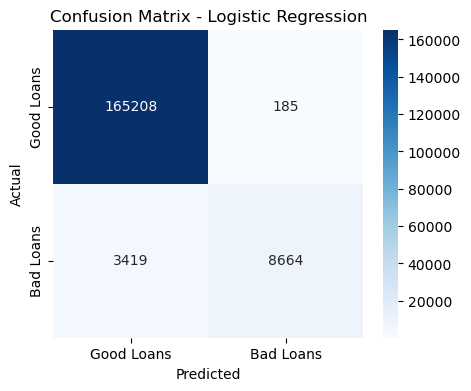

In [17]:
from sklearn.impute import SimpleImputer
# Create pipeline with imputer + scaler + LogisticRegression
logistic_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # <-- this handles NaNs
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])
#fit model
logistic_model.fit(X_train, y_train)
# Evaluate
evaluate_model(logistic_model, X_val, y_val, "Logistic Regression", 0.5)


# Cleaned Logistic Regression


--- Logistic Regression ---
ROC-AUC: 0.9392910108413723
Accuracy: 0.9780139286438729
F1-score: 0.8124939932724652
Precision: 0.9687177724303885
Recall: 0.6996606802946288


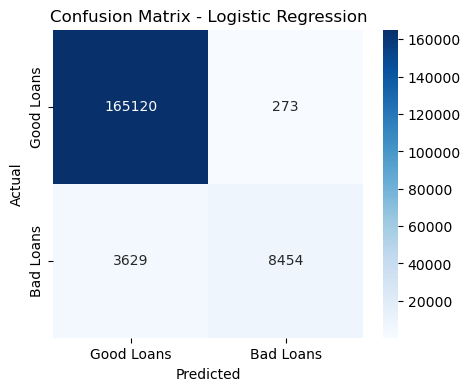

In [18]:
# Remove weak/redundant features
clean_cols = [c for c in X_train.columns if c not in ["funded_amnt", "funded_amnt_inv", "installment"]]

X_train_clean = X_train[clean_cols]
X_val_clean = X_val[clean_cols]

# Pipeline with imputation + scaling + Logistic Regression
cleaned_logistic_model = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),  # handles NaNs
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42, ))
])

# Fit model
cleaned_logistic_model.fit(X_train_clean, y_train)

# Evaluate
evaluate_model(cleaned_logistic_model, X_val_clean, y_val, "Logistic Regression", 0.5)

# Random forest


--- Random Forest ---
ROC-AUC: 0.9505667395062997
Accuracy: 0.9822060447609817
F1-score: 0.8507843507843508
Precision: 0.9914106375949785
Recall: 0.7450964164528676


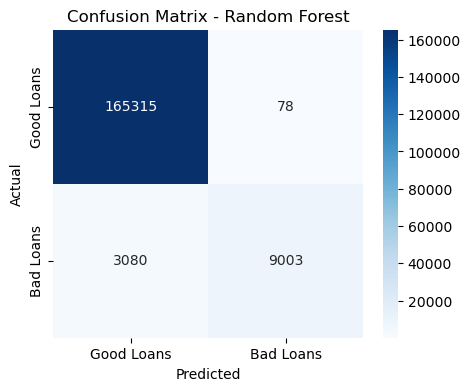

In [19]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

# Fit model on full training data
rf_model.fit(X_train, y_train)

# Evaluate
evaluate_model(rf_model, X_val, y_val, "Random Forest", 0.5)

# XGBoost

In [20]:
# Count positives and negatives
num_positive = sum(y_train == 1)   # number of bad loans
num_negative = sum(y_train == 0)   # number of good loans

# Compute scale_pos_weight
scale_pos_weight = num_negative / num_positive

print("Number of positive samples:", num_positive)
print("Number of negative samples:", num_negative)
print("scale_pos_weight:", scale_pos_weight)

Number of positive samples: 48332
Number of negative samples: 661571
scale_pos_weight: 13.688053463543822



--- XGBoost ---
ROC-AUC: 0.9572028381552253
Accuracy: 0.9709312808492416
F1-score: 0.7898317513341753
Precision: 0.7777599486521181
Recall: 0.8022842009434743


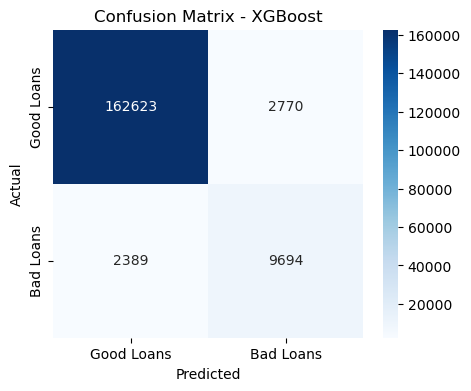

In [21]:
xgb_model = xgb.XGBClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=6, scale_pos_weight=scale_pos_weight,
    random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric="logloss"
)

xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_val, y_val, "XGBoost", 0.5)

# LightGBM

[LightGBM] [Info] Number of positive: 48332, number of negative: 661571
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7114
[LightGBM] [Info] Number of data points in the train set: 709903, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000

--- LightGBM ---
ROC-AUC: 0.9567577883216728
Accuracy: 0.9715567175280038
F1-score: 0.7926047658175842
Precision: 0.78697886921759
Recall: 0.798311677563519


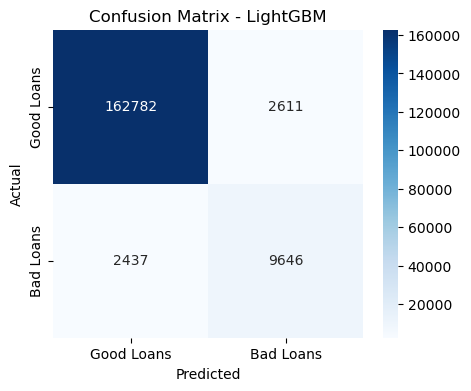

In [22]:
lgb_model = LGBMClassifier(
    n_estimators=500, learning_rate=0.05, num_leaves=32,
    colsample_bytree=0.8, subsample=0.8,
    random_state=42, n_jobs=-1, class_weight='balanced'
)
lgb_model.fit(X_train, y_train)
evaluate_model(lgb_model, X_val, y_val, "LightGBM", 0.5)

# Test Data

In [23]:
#Align Columns with Training Data

# For baseline Logistic Regression
X_test_lr = X_test[X_train.columns]

# For cleaned Logistic Regression
X_test_clean_lr = X_test[X_train_clean.columns]



In [24]:
import numpy as np
from sklearn.metrics import f1_score

# Predict probabilities for the positive class (Bad Loan)
y_prob_val = xgb_model.predict_proba(X_val)[:, 1]

# Try thresholds from 0.1 to 0.9
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = [f1_score(y_val, (y_prob_val >= t).astype(int)) for t in thresholds]

# Find the best threshold
best_threshold = thresholds[np.argmax(f1_scores)]
print("Best threshold for F1-score:", best_threshold)

Best threshold for F1-score: 0.8699999999999996



--- Logistic Regression (Test) ---
ROC-AUC: 0.9119996742589436
Accuracy: 0.9549620853954366
F1-score: 0.684170183685343
Precision: 0.7148205326128908
Recall: 0.6560402387404141


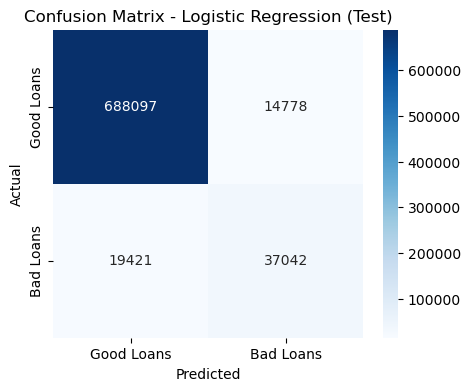

In [25]:
#Evaluate Models on Test Data
# Logistic Regression
evaluate_model(logistic_model, X_test_lr, y_test, "Logistic Regression (Test)", best_threshold)


--- Logistic Regression (Test) ---
ROC-AUC: 0.906702800313844
Accuracy: 0.9502316491470202
F1-score: 0.6508043576688874
Precision: 0.680370942812983
Recall: 0.6237004764181854


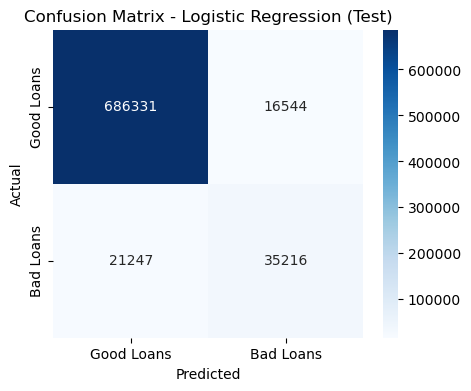

In [26]:
# Cleaned Logistic Regression
evaluate_model(cleaned_logistic_model, X_test_clean_lr, y_test, "Logistic Regression (Test)", best_threshold)


--- Random Forest (Test) ---
ROC-AUC: 0.914381374750033
Accuracy: 0.9747767134003567
F1-score: 0.7975947668213089
Precision: 0.9888114453411592
Recall: 0.6683491844216567


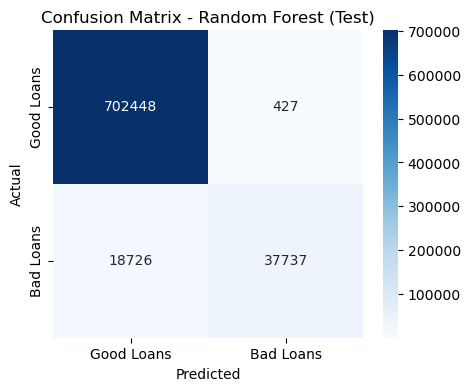

In [29]:
# Random Forest
evaluate_model(rf_model, X_test_lr, y_test, "Random Forest (Test)", 0.5)


--- XGBoost (Test) ---
ROC-AUC: 0.9172688322575894
Accuracy: 0.9678588454680261
F1-score: 0.725355599567879
Precision: 0.994691521866609
Recall: 0.5707985760586579


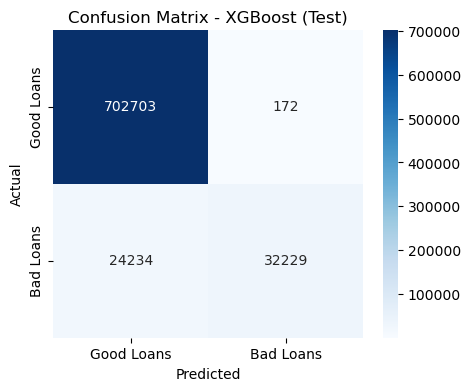

In [30]:
# XGBoost
evaluate_model(xgb_model, X_test_lr, y_test, "XGBoost (Test)", 0.998)


--- LightGBM (Test) ---
ROC-AUC: 0.9234647495907835
Accuracy: 0.9613413262605058
F1-score: 0.7338404765574706
Precision: 0.751802036115033
Recall: 0.7167171421993164


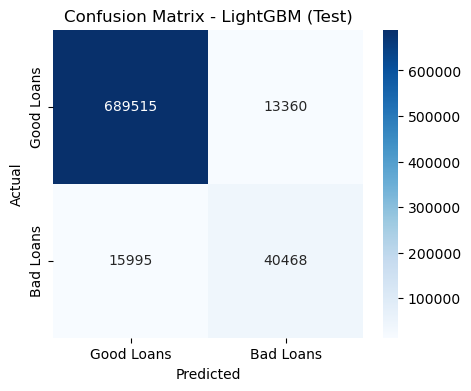

In [31]:
# LightGBM
evaluate_model(lgb_model, X_test_lr, y_test, "LightGBM (Test)", best_threshold)

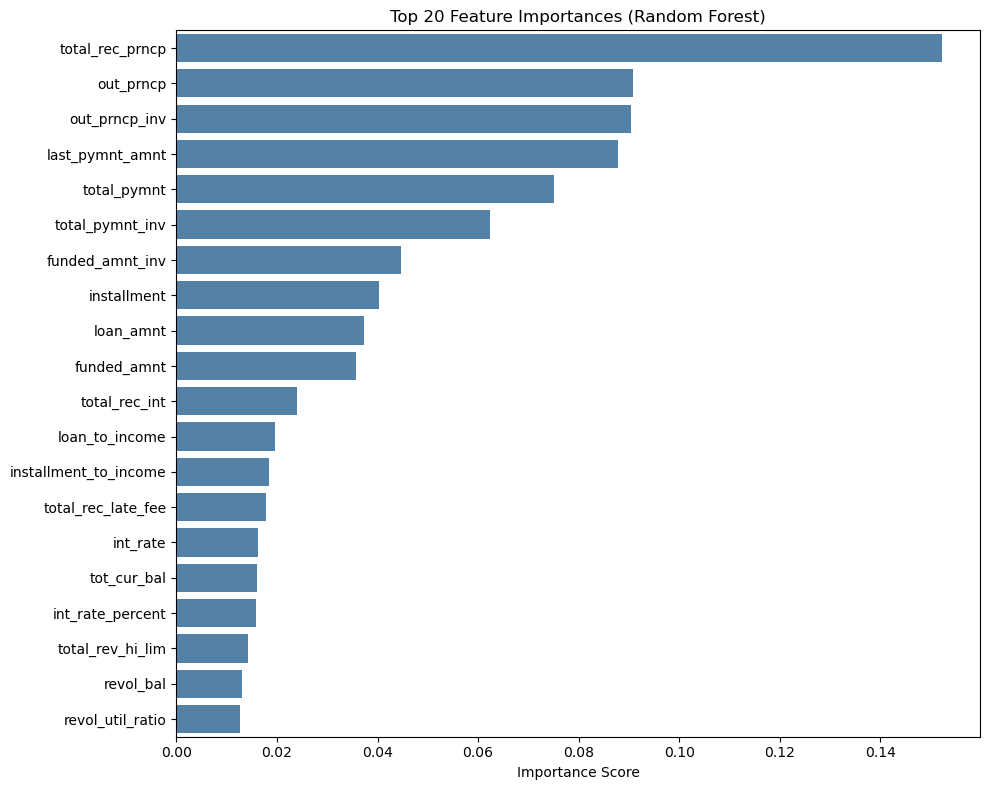

In [32]:
rf_model.fit(X_train, y_train)
feature_names = X_train.columns
importances = rf_model.feature_importances_
rf_feat_importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(
    data=rf_feat_importances.head(20),
    x="Importance",
    y="Feature",
    color="steelblue"
)
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("")
plt.tight_layout()
plt.show()


In [33]:
top_features = rf_feat_importances.head(20)["Feature"].tolist()
print(top_features)


['total_rec_prncp', 'out_prncp', 'out_prncp_inv', 'last_pymnt_amnt', 'total_pymnt', 'total_pymnt_inv', 'funded_amnt_inv', 'installment', 'loan_amnt', 'funded_amnt', 'total_rec_int', 'loan_to_income', 'installment_to_income', 'total_rec_late_fee', 'int_rate', 'tot_cur_bal', 'int_rate_percent', 'total_rev_hi_lim', 'revol_bal', 'revol_util_ratio']
